In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [2]:
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy
import matplotlib.pyplot as plt
from qtpyt.projector import ProjectedGreenFunction
from qtpyt.hybridization import Hybridization
from qtpyt.projector import expand, ExpandSelfEnergy
from qtpyt.base.selfenergy import DataSelfEnergy

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

H_lcao, S_lcao = np.load("dft/device/hs_cc_k.npy")


In [6]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [7]:
E_ref, T_ref = np.load("published_reference/transmission/ET_dft.npy")

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

cutoff = [1,1e-2,1e-4,1e-5,1e-6,1e-8,1e-10,1e-18,1e-40]
# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

nodes = [0,810,1116,1278,1584,2394]

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
eta = 1e-3


In [9]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices) This is here because tests suggest that
# this step needs to be done prior to removing PBC in the aligning Hamiltonian

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao)
remove_pbc(device_basis, S_lcao)

In [10]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

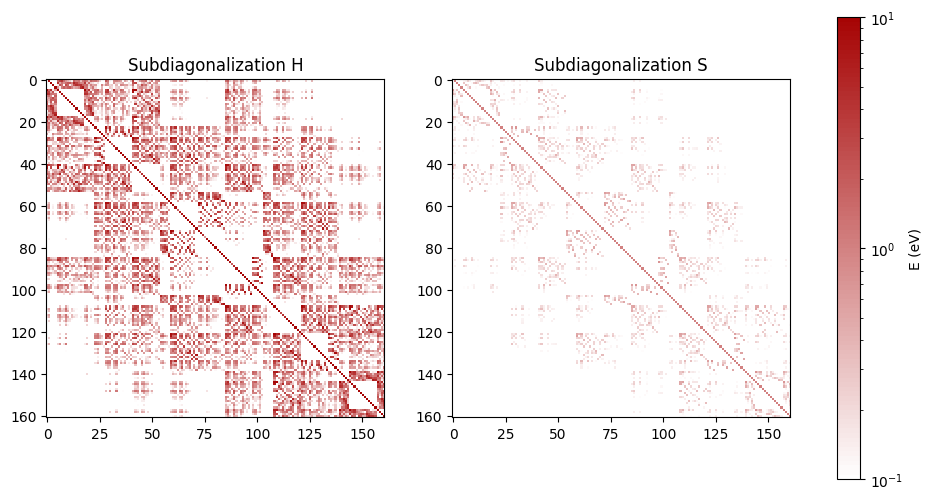

In [11]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao[0], S_lcao[0], a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao[0], Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao[0], Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_sub = S_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonal H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonal S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


### Only C and N 2pz are included in the active space

In [12]:
# Ensure that the active space and embedding region of the Hamiltonian are orthogonal to each other
lowdin = True

active = {'C':[3], 'N':[3]}

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# TODO check if this is the right place to do lowdin orthog
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

    H_lowdin = rotate_matrix(H_subdiagonal[0], Ulow)[None,...]
    S_lowdin = rotate_matrix(S_subdiagonal[0], Ulow)[None,...]


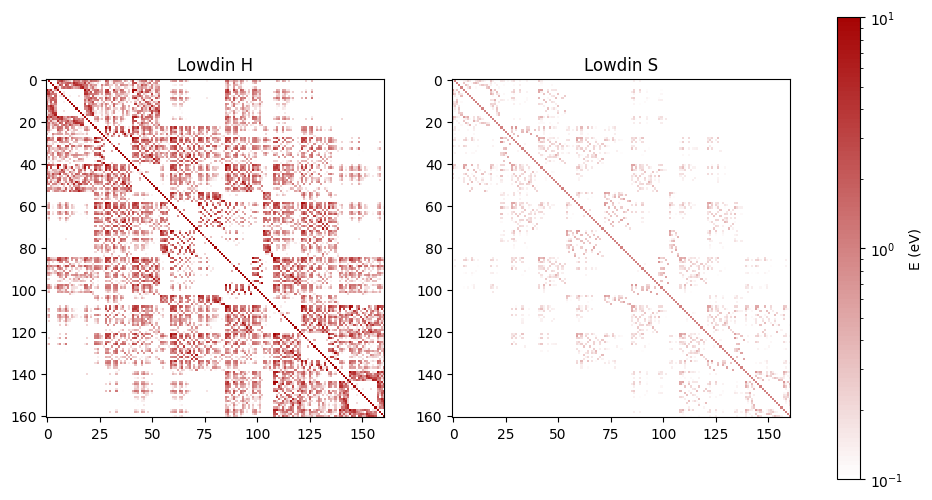

In [13]:
# Extract the bridge regions
bridge_region_H_lowdin = H_lowdin[0,bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_lowdin = S_lowdin[0,bridge_start:bridge_end, bridge_start:bridge_end]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonal H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_lowdin), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Lowdin H")

# Plot the subdiagonal S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_lowdin), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Lowdin S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

### Compute hybridization or embedding self-energy

In [14]:
H_lowdin = H_lowdin.astype(np.complex128)
S_lowdin = S_lowdin.astype(np.complex128)

In [15]:
# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lowdin[0], S_lowdin[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='dyson',
                                 eta=eta)

gfp = ProjectedGreenFunction(gf, index_active_region)
hybr_active = Hybridization(gfp)


In [16]:
n_A = len(index_active_region)
sigma_active = np.empty((energies.size, n_A, n_A), dtype=complex)  # Create 3D array

for e, energy in enumerate(energies):
    sigma_active[e, :, :] = hybr_active.retarded(energy)  # Store the n_A x n_A matrix in sigma_active[e]

imb = 2  # index of molecule block
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = index_active_region - nodes[imb]  # indices of active region w.r.t molecule


In [17]:
dse = DataSelfEnergy(energies, sigma_active)
ese = ExpandSelfEnergy(S_molecule, dse, idx_molecule)
gf.selfenergies.append((imb, ese))

In [18]:
# Calculate the transmission function T for each energy in the defined range
T_active = np.empty(energies.size)
for e, energy in enumerate(energies):
    T_active[e] = gf.get_transmission(energy)  # Compute transmission at each energy point
gf.selfenergies.pop()

(2, <qtpyt.projector.ExpandSelfEnergy at 0x15545c2b1880>)

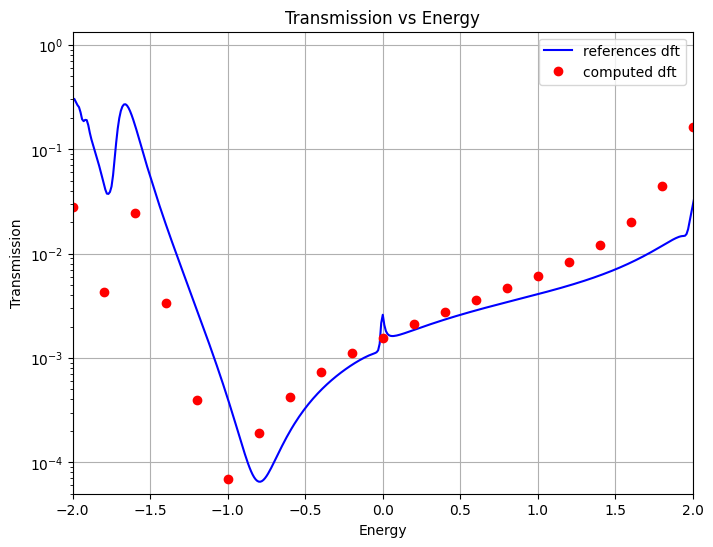

In [19]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the reference DFT data
plt.plot(E_ref, T_ref, label="references dft", color='blue')

# Plot the computed DFT data
plt.plot(energies, T_active, 'o', label="computed dft", color='red')

# Set the y-axis to log scale
plt.yscale("log")

# Set x-axis limits
plt.xlim(-2, 2)

# Set y-axis limits, bottom starting at 5e-5
plt.ylim(bottom=5e-5)

# Add a legend to distinguish between the reference and computed data
plt.legend()

# Add labels for the axes
plt.xlabel('Energy')
plt.ylabel('Transmission')

# Add a title (optional)
plt.title('Transmission vs Energy')

# Show the grid for better readability
plt.grid(True)

# Display the plot
plt.show()

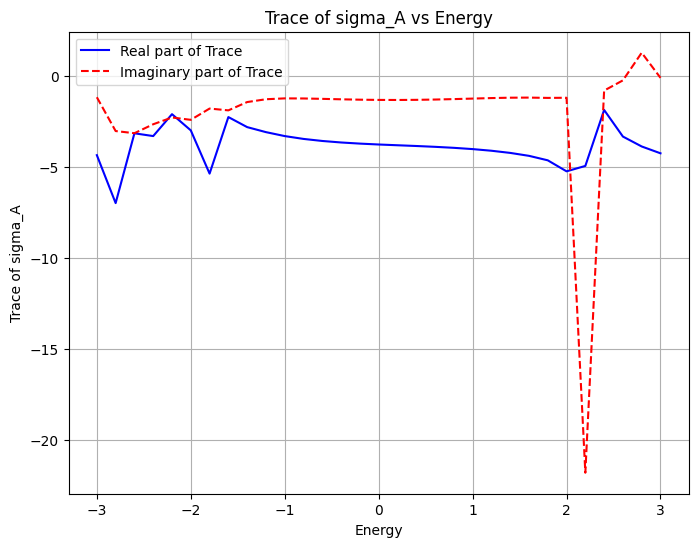

In [20]:
n_A = len(index_active_region)
sigma_active = np.empty((energies.size, n_A, n_A), dtype=complex)  # Create 3D array

# Initialize an array to store the trace for each energy
trace_sigma_active = np.empty(energies.size, dtype=complex)

# Loop through energies and compute the trace for each corresponding sigma_active
for e, energy in enumerate(energies):
    sigma_active[e, :, :] = hybr_active.retarded(energy)  # Store the n_A x n_A matrix in sigma_active[e]
    trace_sigma_active[e] = np.trace(sigma_active[e, :, :])  # Compute the trace and store it
    
# Now plot the trace vs energy
plt.figure(figsize=(8, 6))
plt.plot(energies, trace_sigma_active.real, label='Real part of Trace', color='b')
plt.plot(energies, trace_sigma_active.imag, label='Imaginary part of Trace', color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Trace of sigma_active')
plt.title('Trace of sigma_active vs Energy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Analysis

- In the above computation of T(E), the following steps are taken
  - The self energy of the left and right leads are computed. (How should we take into account the Au tips?)
  - The Hamiltonian of the device (leads + bridge molecule) is subdiagonalized on the C, N and H atoms.
  - The 2pz orbitals of C and N are chosen to be the active region.
  - Lowdin orthogonalization is carried out on the device Hamiltonian with the active indices passed into the lowdin orthogonalization function. This step is not quite clear to me. Is there a way to verify the Lowdin orthogonalization is being done correctly?
  - Hybridization of the active space with the environment is computed
  - The Lowdin orthogonalized H, S of the device are tridiagonalized. 
  - Green's function is computed with information from the tridiagonalized device Hamiltonian and the self-energies of the left and right leads and the active space hybridization with the environment.
  
### Conclusion

- The transmission computed using the embedding method produces a transmission function different from the reference DFT T(E). I vaguely remember from one of our meetings, you mentioned that the T(E) after the embedding procedure should match the T(E) from the DFT calculation. Is this true or am I misremembering? If it is true, I am having a hard time understanding why that should be the case. It also indicates that the embedding procedure I have implemented is still missing some steps.  
- If the embedding procedure is wrong, what are the possible ways to debug? Looking at the Tr(sigma)? Something else?


### The entire molecule is included in the active space

In [21]:
# Ensure that the active space and embedding region of the Hamiltonian are orthogonal to each other
lowdin = True

active = {'C':list(range(13)), 'N':list(range(13)), 'H':list(range(5))}

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

    H_lowdin = rotate_matrix(H_subdiagonal[0], Ulow)[None,...]
    S_lowdin = rotate_matrix(S_subdiagonal[0], Ulow)[None,...]
    
H_lowdin = H_lowdin.astype(np.complex128)
S_lowdin = S_lowdin.astype(np.complex128)

In [22]:
# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lowdin[0], S_lowdin[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='dyson',
                                 eta=eta)

gfp = ProjectedGreenFunction(gf, index_active_region)
hybr_active = Hybridization(gfp)

In [23]:
n_A = len(index_active_region)
sigma_active = np.empty((energies.size, n_A, n_A), dtype=complex)  # Create 3D array

for e, energy in enumerate(energies):
    sigma_active[e, :, :] = hybr_active.retarded(energy)  # Store the n_A x n_A matrix in sigma_active[e]

imb = 2  # index of molecule block
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = index_active_region - nodes[imb]  # indices of active region w.r.t molecule


In [24]:
dse = DataSelfEnergy(energies, sigma_active)
ese = ExpandSelfEnergy(S_molecule, dse, idx_molecule)
gf.selfenergies.append((imb, ese))

In [25]:
# Calculate the transmission function T for each energy in the defined range
T = np.empty(energies.size)
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point
gf.selfenergies.pop()

(2, <qtpyt.projector.ExpandSelfEnergy at 0x1554f1645fd0>)

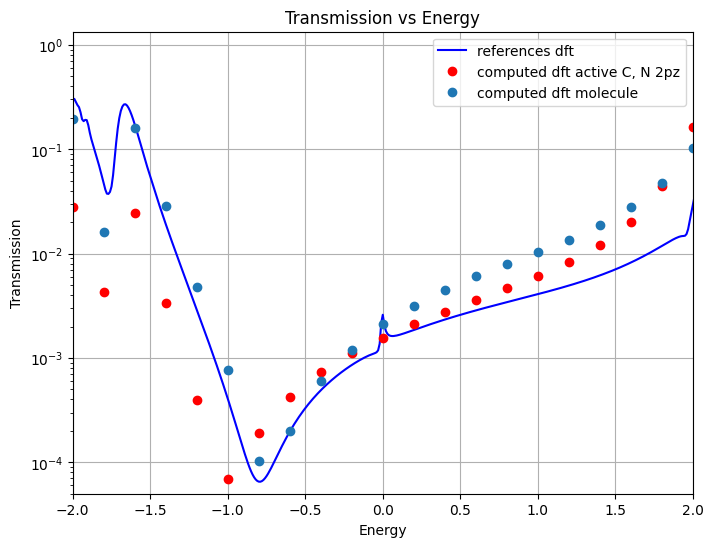

In [26]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the reference DFT data
plt.plot(E_ref, T_ref, label="references dft", color='blue')

# Plot the computed DFT data
plt.plot(energies, T_active, 'o', label="computed dft active C, N 2pz", color='red')

plt.plot(energies, T, 'o', label="computed dft molecule")

# Set the y-axis to log scale
plt.yscale("log")

# Set x-axis limits
plt.xlim(-2, 2)

# Set y-axis limits, bottom starting at 5e-5
plt.ylim(bottom=5e-5)

# Add a legend to distinguish between the reference and computed data
plt.legend()

# Add labels for the axes
plt.xlabel('Energy')
plt.ylabel('Transmission')

# Add a title (optional)
plt.title('Transmission vs Energy')

# Show the grid for better readability
plt.grid(True)

# Display the plot
plt.show()

### Analysis

- In the above computation of T(E), the only difference is that the entire molecule is considered to be the active space (not just C and N 2 pz) for the embedding procedure. This was merely to see how the T(E) is affected by this change.
  
### Conclusion

- The transmission computed using the entire molecule as the active space is different from when only the C, N 2 pz is considered to be the active space. Is it naive to think these should match since in both cases, the effect of the environment is being considered through the embedding procedure?
